In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import optimizers
from keras import losses
from keras import metrics
from keras import regularizers
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorboard.plugins.hparams import api as hp
from sklearn.model_selection import train_test_split, GridSearchCV
from scikeras.wrappers import KerasClassifier


In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784
k = 10000 # кількість даних під тест

In [3]:
# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data= np.c_[(x_train), y_train]
np.random.shuffle(train_data)

train_data_X = train_data[:, :-1]
train_data_y = train_data[:, -1]

train_data_y = to_categorical(train_data_y, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [4]:
x_val = train_data_X[:k]
partial_x_train = train_data_X[k:]

y_val = train_data_y[:k]
partial_y_train = train_data_y[k:]

# units = [1000, 2000, 3000]
# batches = [1024, 2048]
# dropouts = [0.0, 0.1, 0,2]
activations = ['relu', 'leaky_relu', 'softplus', 'gelu', 'mish', 'tanh']

In [5]:
def create_model(units=1000, activation='relu', dropout=0.0, regularizer=0.0):
    model = Sequential([
        Dense(units, activation=activation, input_shape=(num_features,), kernel_regularizer=regularizers.L2(regularizer)),
        Dropout(0.5),
        Dense(num_classes, activation='sigmoid')], 
        name=f"model_{activation}_reg-{regularizer}"
    )

    model.compile(
        optimizer=optimizers.legacy.Adam(),
        loss=metrics.categorical_crossentropy,
        metrics=['accuracy']
    )
    return model

In [6]:
def create_plot(history):

    history = history.history
    loss_values = history['loss']
    val_loss_values = history['val_loss']

    epochs = range(1, len(history['accuracy']) + 1)

    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.clf()
    val_acc_values = history['val_accuracy']
    plt.plot(epochs, history['accuracy'], 'bo', label='Training acc')
    plt.plot(epochs, history['val_accuracy'], 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

In [7]:
!rm -rf ./logs/

In [8]:
def create_models(units=100, batch=512, dropout=0.0, regularizer=0.0):
    
    total_test_accuracy = 0
    history_dict = {}

    for activation in activations:

        print("")
        print(f'units: {units}, batch: {batch}, activation: {activation}, regularizer: {regularizer}')

        model = create_model(units, activation, dropout, regularizer)


        log_folder = f"./logs/fit/model_{activation}/units-{units}/drop-{dropout}"
        early_stopping = EarlyStopping(patience=20, monitor='val_accuracy')
        checkpoint = ModelCheckpoint('best_model_checkpoint.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)
        tensorboard = TensorBoard(log_dir=log_folder)


        history = model.fit(
            partial_x_train,
            partial_y_train,
            epochs=120,
            batch_size=batch,
            validation_data=(x_val, y_val),
            callbacks=[checkpoint, early_stopping, tensorboard]

        )

        test_loss, test_accuracy = model.evaluate(x_test, y_test)
        print('Test loss: ', test_loss)
        print('Test accuracy: ', test_accuracy)

        if test_accuracy > total_test_accuracy:
            total_test_accuracy = test_accuracy
            history_dict = history

            model.save("best_model.keras")
            model.summary()

        create_plot(history_dict)
        
    return history_dict


units: 1000, batch: 1024, activation: relu, regularizer: 0.0


2024-02-14 00:37:05.985986: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-02-14 00:37:05.986068: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-02-14 00:37:05.986090: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-02-14 00:37:05.986224: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-14 00:37:05.986310: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/120


2024-02-14 00:37:06.878453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


49/49 [==============================] - 4s 31ms/step - loss: 0.9051 - accuracy: 0.6901 - val_loss: 0.5485 - val_accuracy: 0.8128
Epoch 2/120
49/49 [==============================] - 1s 13ms/step - loss: 0.5997 - accuracy: 0.7969 - val_loss: 0.5014 - val_accuracy: 0.8322
Epoch 3/120
49/49 [==============================] - 1s 13ms/step - loss: 0.5389 - accuracy: 0.8168 - val_loss: 0.4707 - val_accuracy: 0.8435
Epoch 4/120
49/49 [==============================] - 1s 13ms/step - loss: 0.5104 - accuracy: 0.8256 - val_loss: 0.4746 - val_accuracy: 0.8423
Epoch 5/120
49/49 [==============================] - 1s 13ms/step - loss: 0.4935 - accuracy: 0.8315 - val_loss: 0.4657 - val_accuracy: 0.8443
Epoch 6/120
49/49 [==============================] - 1s 13ms/step - loss: 0.4791 - accuracy: 0.8344 - val_loss: 0.4445 - val_accuracy: 0.8520
Epoch 7/120
49/49 [==============================] - 1s 13ms/step - loss: 0.4707 - accuracy: 0.8383 - val_loss: 0.4468 - val_accuracy: 0.8495
Epoch 8/120
49/49 

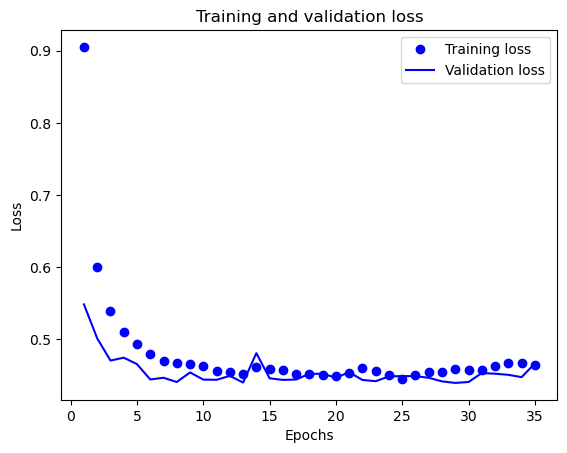

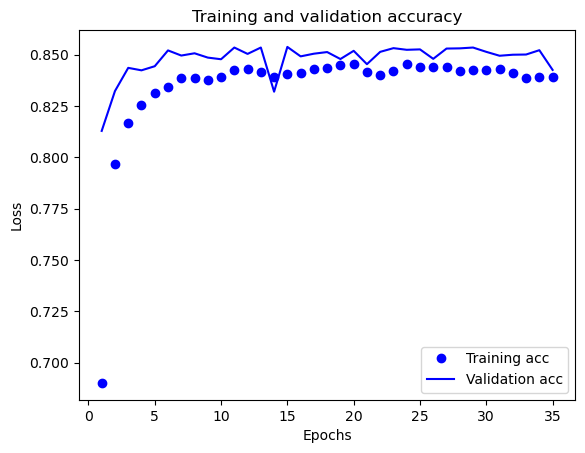


units: 1000, batch: 1024, activation: leaky_relu, regularizer: 0.0
Epoch 1/120
49/49 [==============================] - 1s 15ms/step - loss: 0.7620 - accuracy: 0.7319 - val_loss: 0.5133 - val_accuracy: 0.8282
Epoch 2/120
49/49 [==============================] - 1s 14ms/step - loss: 0.4872 - accuracy: 0.8315 - val_loss: 0.4530 - val_accuracy: 0.8444
Epoch 3/120
49/49 [==============================] - 1s 14ms/step - loss: 0.4388 - accuracy: 0.8462 - val_loss: 0.4264 - val_accuracy: 0.8556
Epoch 4/120
49/49 [==============================] - 1s 14ms/step - loss: 0.4119 - accuracy: 0.8549 - val_loss: 0.4061 - val_accuracy: 0.8599
Epoch 5/120
49/49 [==============================] - 1s 14ms/step - loss: 0.3909 - accuracy: 0.8615 - val_loss: 0.3908 - val_accuracy: 0.8625
Epoch 6/120
49/49 [==============================] - 1s 14ms/step - loss: 0.3768 - accuracy: 0.8668 - val_loss: 0.3812 - val_accuracy: 0.8668
Epoch 7/120
49/49 [==============================] - 1s 14ms/step - loss: 0.3696

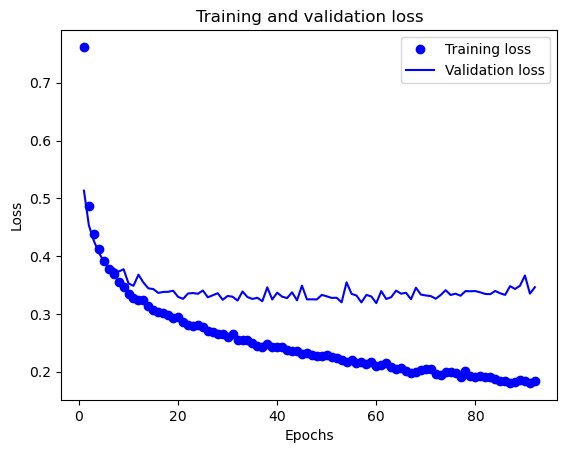

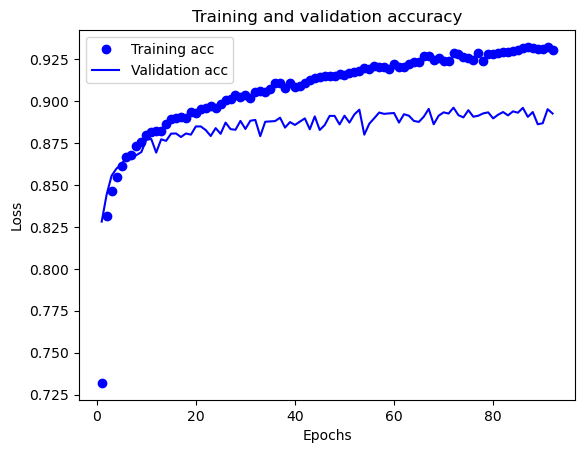


units: 1000, batch: 1024, activation: softplus, regularizer: 0.0
Epoch 1/120
49/49 [==============================] - 1s 20ms/step - loss: 1.0133 - accuracy: 0.6431 - val_loss: 0.5769 - val_accuracy: 0.7959
Epoch 2/120
49/49 [==============================] - 1s 18ms/step - loss: 0.5849 - accuracy: 0.7877 - val_loss: 0.5149 - val_accuracy: 0.8157
Epoch 3/120
49/49 [==============================] - 1s 19ms/step - loss: 0.5296 - accuracy: 0.8086 - val_loss: 0.4792 - val_accuracy: 0.8336
Epoch 4/120
49/49 [==============================] - 1s 19ms/step - loss: 0.4922 - accuracy: 0.8234 - val_loss: 0.4583 - val_accuracy: 0.8394
Epoch 5/120
49/49 [==============================] - 1s 18ms/step - loss: 0.4680 - accuracy: 0.8322 - val_loss: 0.4430 - val_accuracy: 0.8469
Epoch 6/120
49/49 [==============================] - 1s 19ms/step - loss: 0.4490 - accuracy: 0.8360 - val_loss: 0.4313 - val_accuracy: 0.8502
Epoch 7/120
49/49 [==============================] - 1s 18ms/step - loss: 0.4396 -

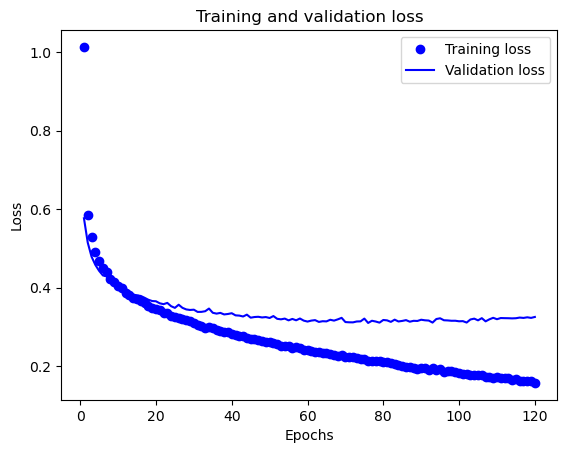

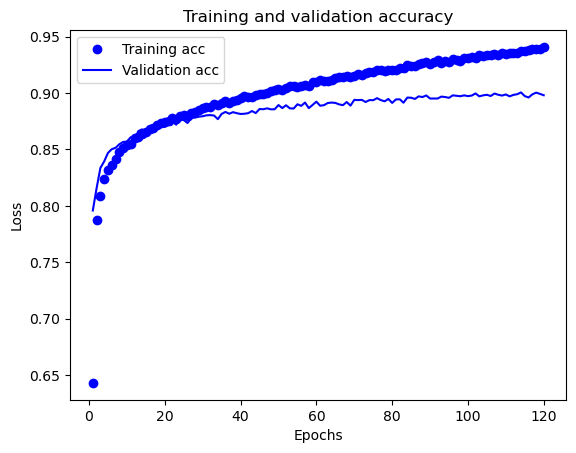


units: 1000, batch: 1024, activation: gelu, regularizer: 0.0
Epoch 1/120
49/49 [==============================] - 1s 17ms/step - loss: 0.7533 - accuracy: 0.7380 - val_loss: 0.5066 - val_accuracy: 0.8272
Epoch 2/120
49/49 [==============================] - 1s 15ms/step - loss: 0.4770 - accuracy: 0.8340 - val_loss: 0.4603 - val_accuracy: 0.8393
Epoch 3/120
49/49 [==============================] - 1s 15ms/step - loss: 0.4345 - accuracy: 0.8463 - val_loss: 0.4168 - val_accuracy: 0.8583
Epoch 4/120
49/49 [==============================] - 1s 15ms/step - loss: 0.4006 - accuracy: 0.8568 - val_loss: 0.3962 - val_accuracy: 0.8629
Epoch 5/120
49/49 [==============================] - 1s 15ms/step - loss: 0.3772 - accuracy: 0.8644 - val_loss: 0.3911 - val_accuracy: 0.8638
Epoch 6/120
49/49 [==============================] - 1s 15ms/step - loss: 0.3646 - accuracy: 0.8687 - val_loss: 0.3732 - val_accuracy: 0.8688
Epoch 7/120
49/49 [==============================] - 1s 15ms/step - loss: 0.3491 - acc

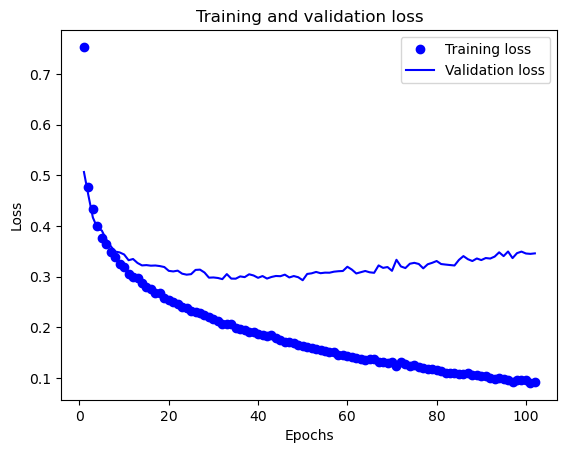

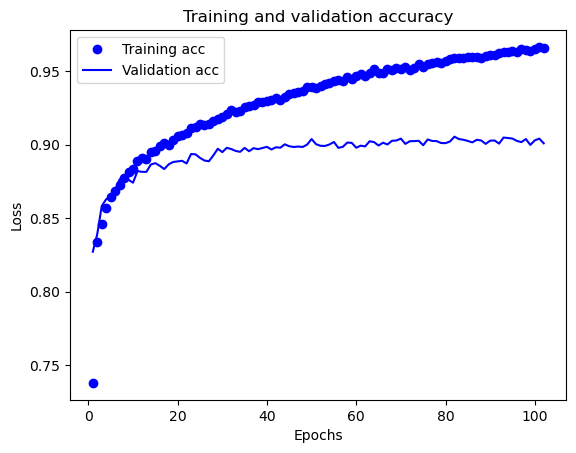


units: 1000, batch: 1024, activation: mish, regularizer: 0.0
Epoch 1/120
49/49 [==============================] - 1s 23ms/step - loss: 0.7490 - accuracy: 0.7383 - val_loss: 0.5098 - val_accuracy: 0.8272
Epoch 2/120
49/49 [==============================] - 1s 19ms/step - loss: 0.4822 - accuracy: 0.8306 - val_loss: 0.4510 - val_accuracy: 0.8427
Epoch 3/120
49/49 [==============================] - 1s 20ms/step - loss: 0.4388 - accuracy: 0.8438 - val_loss: 0.4270 - val_accuracy: 0.8551
Epoch 4/120
49/49 [==============================] - 1s 20ms/step - loss: 0.4117 - accuracy: 0.8546 - val_loss: 0.4070 - val_accuracy: 0.8602
Epoch 5/120
49/49 [==============================] - 1s 20ms/step - loss: 0.3935 - accuracy: 0.8595 - val_loss: 0.3927 - val_accuracy: 0.8636
Epoch 6/120
49/49 [==============================] - 1s 20ms/step - loss: 0.3789 - accuracy: 0.8642 - val_loss: 0.3813 - val_accuracy: 0.8678
Epoch 7/120
49/49 [==============================] - 1s 21ms/step - loss: 0.3632 - acc

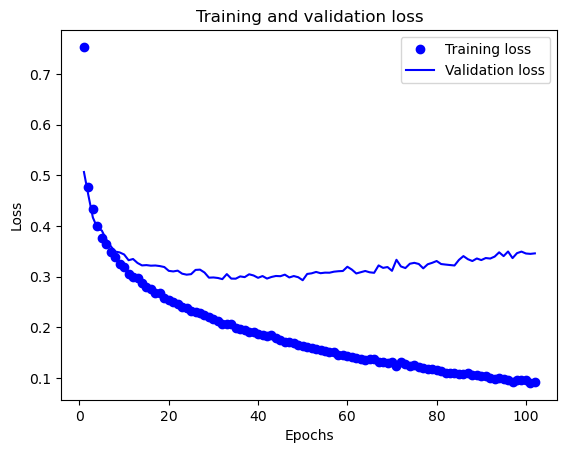

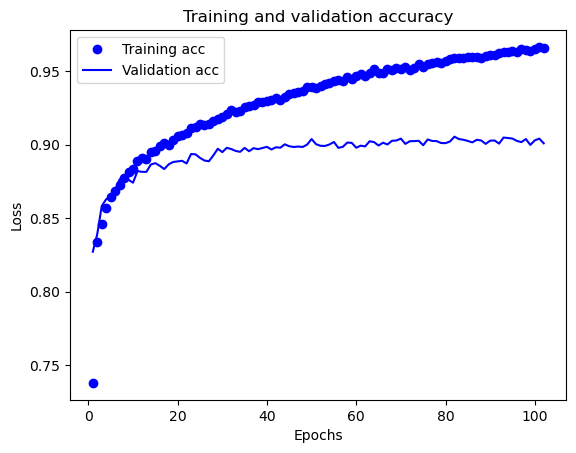


units: 1000, batch: 1024, activation: tanh, regularizer: 0.0
Epoch 1/120
49/49 [==============================] - 1s 16ms/step - loss: 0.8145 - accuracy: 0.7135 - val_loss: 0.5191 - val_accuracy: 0.8225
Epoch 2/120
49/49 [==============================] - 1s 14ms/step - loss: 0.5074 - accuracy: 0.8202 - val_loss: 0.4660 - val_accuracy: 0.8389
Epoch 3/120
49/49 [==============================] - 1s 14ms/step - loss: 0.4656 - accuracy: 0.8374 - val_loss: 0.4615 - val_accuracy: 0.8433
Epoch 4/120
49/49 [==============================] - 1s 14ms/step - loss: 0.4513 - accuracy: 0.8397 - val_loss: 0.4349 - val_accuracy: 0.8505
Epoch 5/120
49/49 [==============================] - 1s 14ms/step - loss: 0.4291 - accuracy: 0.8482 - val_loss: 0.4294 - val_accuracy: 0.8520
Epoch 6/120
49/49 [==============================] - 1s 14ms/step - loss: 0.4170 - accuracy: 0.8528 - val_loss: 0.4214 - val_accuracy: 0.8565
Epoch 7/120
49/49 [==============================] - 1s 14ms/step - loss: 0.4079 - acc

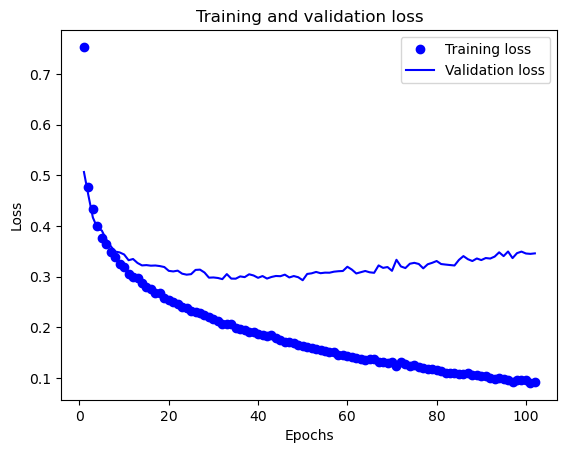

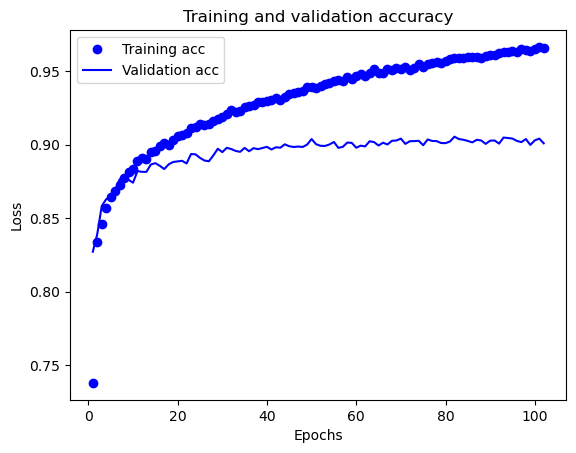

In [9]:
units = 1000
batch = 1024

history = create_models(units, batch)

In [10]:
model = keras.models.load_model("best_model.keras")
model.summary()
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {test_loss}, test accuracy: {test_accuracy}")

Model: "model_gelu_reg-0.0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1000)              785000    
                                                                 
 dropout_3 (Dropout)         (None, 1000)              0         
                                                                 
 dense_7 (Dense)             (None, 10)                10010     
                                                                 
Total params: 795010 (3.03 MB)
Trainable params: 795010 (3.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
313/313 [==============================] - 2s 6ms/step - loss: 0.3604 - accuracy: 0.9042
Test loss: 0.3603895604610443, test accuracy: 0.90420001745224


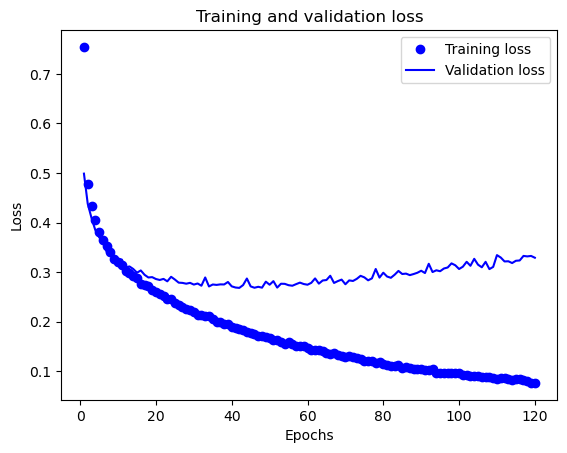

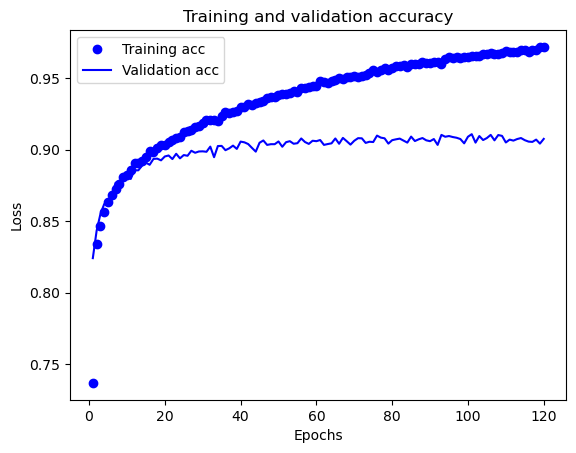

In [44]:
create_plot(history)

In [11]:
%load_ext tensorboard

In [12]:
%tensorboard --logdir logs/fit/model_gelu

#### Візьмемо ті самі дані і спробуємо збільшити точність моделі за рахунок dropout

In [14]:
units = 1000
batch = 1024
activation = "gelu"
dropout = 0.3
regularizer = 0.0


print("")
print(f'units: {units}, batch: {batch}, activation: {activation}, dropout: {dropout}, regularizer: {regularizer}')

model = create_model(units, activation, dropout, regularizer)


!rm -rf ./logs/fit/model_{activation}/units-{units}/drop-{dropout}/reg-{regularizer}/
log_folder = f"./logs/fit/model_{activation}/units-{units}/drop-{dropout}/reg-{regularizer}"

early_stopping = EarlyStopping(patience=20, monitor='val_accuracy')
checkpoint = ModelCheckpoint('best_model_checkpoint.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)
tensorboard = TensorBoard(log_dir=log_folder)


history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=150,
    batch_size=batch,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint, early_stopping, tensorboard]

)

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)


units: 1000, batch: 1024, activation: gelu, dropout: 0.3, regularizer: 0.0
Epoch 1/150
49/49 [==============================] - 1s 19ms/step - loss: 0.7529 - accuracy: 0.7389 - val_loss: 0.5071 - val_accuracy: 0.8293
Epoch 2/150
49/49 [==============================] - 1s 15ms/step - loss: 0.4819 - accuracy: 0.8304 - val_loss: 0.4540 - val_accuracy: 0.8385
Epoch 3/150
49/49 [==============================] - 1s 15ms/step - loss: 0.4288 - accuracy: 0.8476 - val_loss: 0.4137 - val_accuracy: 0.8588
Epoch 4/150
49/49 [==============================] - 1s 15ms/step - loss: 0.4018 - accuracy: 0.8561 - val_loss: 0.3936 - val_accuracy: 0.8659
Epoch 5/150
49/49 [==============================] - 1s 14ms/step - loss: 0.3794 - accuracy: 0.8632 - val_loss: 0.3857 - val_accuracy: 0.8637
Epoch 6/150
49/49 [==============================] - 1s 14ms/step - loss: 0.3628 - accuracy: 0.8685 - val_loss: 0.3714 - val_accuracy: 0.8657
Epoch 7/150
49/49 [==============================] - 1s 15ms/step - loss

In [15]:
model.save("best_model_gelu.keras")
model.summary()

Model: "model_gelu_reg-0.0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 1000)              785000    
                                                                 
 dropout_7 (Dropout)         (None, 1000)              0         
                                                                 
 dense_15 (Dense)            (None, 10)                10010     
                                                                 
Total params: 795010 (3.03 MB)
Trainable params: 795010 (3.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


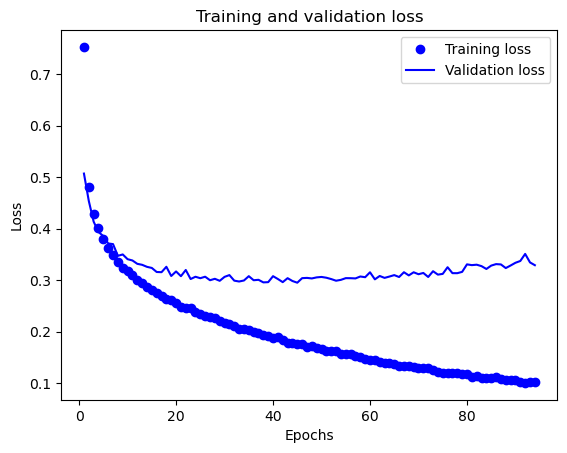

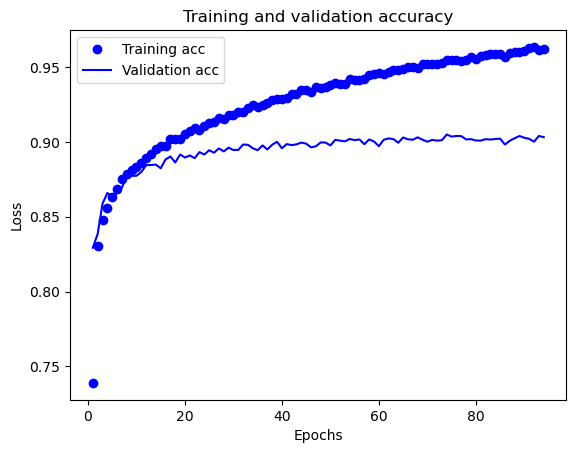

In [16]:
create_plot(history)

In [17]:
%tensorboard --logdir logs/fit/model_gelu/units-1000/drop-0.3

### на графіках можна помітити перенавчання

In [36]:
units = 1000
batch = 1024
activation = "gelu"
dropout = 0.3
regularizer = 0.0001


print("")
print(f'units: {units}, batch: {batch}, activation: {activation}, dropout: {dropout}, regularizer: {regularizer}')

model = create_model(units, activation, dropout, regularizer)

!rm -rf ./logs/fit/model_{activation}/units-{units}/drop-{dropout}/reg-{regularizer}/
log_folder = f"./logs/fit/model_{activation}/units-{units}/drop-{dropout}/reg-{regularizer}"

early_stopping = EarlyStopping(patience=20, monitor='val_accuracy')
checkpoint = ModelCheckpoint('best_model_checkpoint.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=0)
tensorboard = TensorBoard(log_dir=log_folder)


history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=100,
    batch_size=batch,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint, early_stopping, tensorboard]

)

test_loss, test_accuracy = model.evaluate(x_test, y_test)
print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)


units: 1000, batch: 1024, activation: gelu, dropout: 0.3, regularizer: 0.0001
Epoch 1/100
49/49 [==============================] - 1s 24ms/step - loss: 0.8782 - accuracy: 0.7260 - val_loss: 0.6067 - val_accuracy: 0.8222
Epoch 2/100
49/49 [==============================] - 1s 19ms/step - loss: 0.5753 - accuracy: 0.8283 - val_loss: 0.5380 - val_accuracy: 0.8446
Epoch 3/100
49/49 [==============================] - 1s 18ms/step - loss: 0.5225 - accuracy: 0.8461 - val_loss: 0.5060 - val_accuracy: 0.8543
Epoch 4/100
49/49 [==============================] - 1s 18ms/step - loss: 0.4927 - accuracy: 0.8525 - val_loss: 0.4834 - val_accuracy: 0.8637
Epoch 5/100
49/49 [==============================] - 1s 19ms/step - loss: 0.4695 - accuracy: 0.8599 - val_loss: 0.4625 - val_accuracy: 0.8677
Epoch 6/100
49/49 [==============================] - 1s 18ms/step - loss: 0.4527 - accuracy: 0.8661 - val_loss: 0.4582 - val_accuracy: 0.8659
Epoch 7/100
49/49 [==============================] - 1s 18ms/step - l

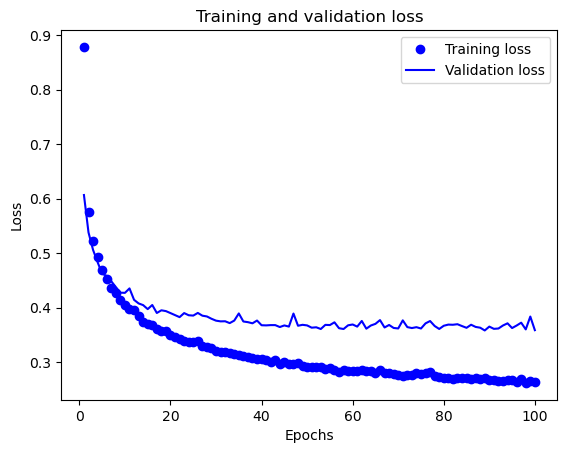

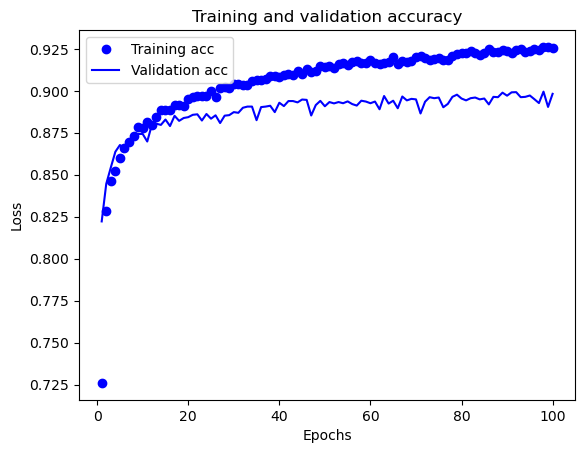

In [37]:
create_plot(history)

In [39]:
%tensorboard --logdir logs/fit/model_gelu/units-1000/drop-0.3/reg-0.0001/